# Imports

In [72]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import kaggle as kg
import os

import seaborn as sns

# 1) Downloading the Dataset using the Kaggle API

## 1a) Get the Kaggle API key
to get the API key:
- go to kaggle website
- click on your profile in the top-right of the page
- click settings
- under the account section scroll down and click on 'create new token'
    - this installs a file called kaggle.json
- move kaggle.json to "C:\Users\benat\ .kaggle"

## 1b) authenticate Kaggle API key (keeping the username and key private)
- create a .env file in the directory containing the username and key in your kaggle.json

KAGGLE_USERNAME=username

KAGGLE_KEY=key

- create a .gitignore and add a line '.env' to ensure the username and key don't get committed to GitHub and become public

- use the code below to use the username and key to authenticate the API

In [2]:
from dotenv import load_dotenv
load_dotenv()

kg.api.authenticate()

## 1c) Download the dataset using the Kaggle API

In [3]:
kg.api.dataset_download_files(
    dataset="utkarshx27/breast-cancer-dataset-used-royston-and-altman", 
    path='../data', # goes back one folder from src in the filepath hierarchy
    unzip=True)

Dataset URL: https://www.kaggle.com/datasets/utkarshx27/breast-cancer-dataset-used-royston-and-altman


# 2) EDA

## 2a) read in the csv and check its contents

In [19]:
df = pd.read_csv('../data/gbsg.csv', index_col='Unnamed: 0')
display(df.head())
display(df.describe())
display(df.info())

,pid,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
1,132,49,0,18,2,2,0,0,0,1838,0
2,1575,55,1,20,3,16,0,0,0,403,1
3,1140,56,1,40,3,3,0,0,0,1603,0
4,769,45,0,25,3,1,0,4,0,177,0
5,130,65,1,30,2,5,0,36,1,1855,0


,pid,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,966.061224,53.052478,0.577259,29.329446,2.116618,5.010204,109.995627,96.252187,0.358601,1124.489796,0.435860
std,495.506249,10.120739,0.494355,14.296217,0.582808,5.475483,202.331552,153.083963,0.479940,642.791948,0.496231
min,1.000000,21.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000,0.000000
25%,580.750000,46.000000,0.000000,20.000000,2.000000,1.000000,7.000000,8.000000,0.000000,567.750000,0.000000
50%,1015.500000,53.000000,1.000000,25.000000,2.000000,3.000000,32.500000,36.000000,0.000000,1084.000000,0.000000
75%,1340.500000,61.000000,1.000000,35.000000,2.000000,7.000000,131.750000,114.000000,1.000000,1684.750000,1.000000
max,1819.000000,80.000000,1.000000,120.000000,3.000000,51.000000,2380.000000,1144.000000,1.000000,2659.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 686 entries, 1 to 686
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   pid      686 non-null    int64
 1   age      686 non-null    int64
 2   meno     686 non-null    int64
 3   size     686 non-null    int64
 4   grade    686 non-null    int64
 5   nodes    686 non-null    int64
 6   pgr      686 non-null    int64
 7   er       686 non-null    int64
 8   hormon   686 non-null    int64
 9   rfstime  686 non-null    int64
 10  status   686 non-null    int64
dtypes: int64(11)
memory usage: 64.3 KB


None

## Columns
- pid = patient ID
- age (years)
- meno = menopausal (0=pre-meno, 1=post-meno)
- size = tumour size in mm
- grade = tumour grade
- nodes = number of positive lymph nodes
- pgr = progesterone receptors (fmol/l)
- er = estrogen receptors (fmol/l)
- hormon = hormonal therapy (0=no, 1=yes)
- rfstime = recurrence free survival time (days)
- status = 0=alive without recurrence, 1=recurrence or death

patient ID won't have any meaningful relationships with any features so remove it

In [85]:
df = df.drop('pid', axis=1)

In [86]:
binary_features = ['meno','hormon','status']
binary_df = df[binary_features]

ordinal_features = ['grade']
ordinal_df = df[ordinal_features]

continuous_features = ['age', 'size', 'nodes', 'pgr', 'er', 'rfstime']
continuous_df = df[continuous_features]

## 2b) plot the features

array([[<Axes: title={'center': 'meno'}>,
        <Axes: title={'center': 'hormon'}>],
       [<Axes: title={'center': 'status'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'grade'}>]], dtype=object)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'nodes'}>,
        <Axes: title={'center': 'pgr'}>],
       [<Axes: title={'center': 'er'}>,
        <Axes: title={'center': 'rfstime'}>]], dtype=object)

<Axes: >

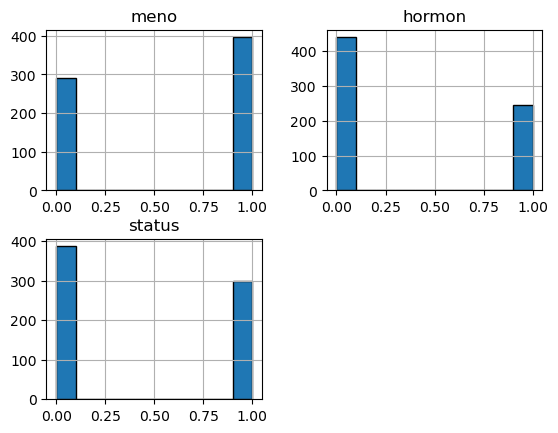

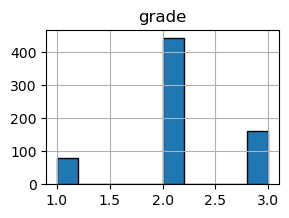

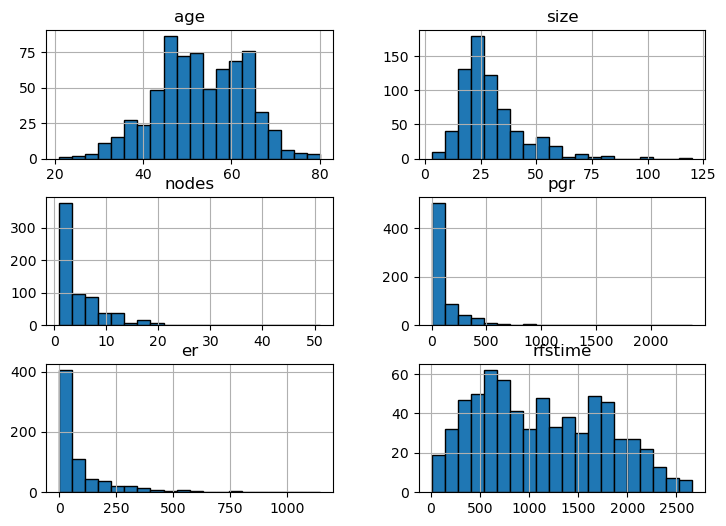

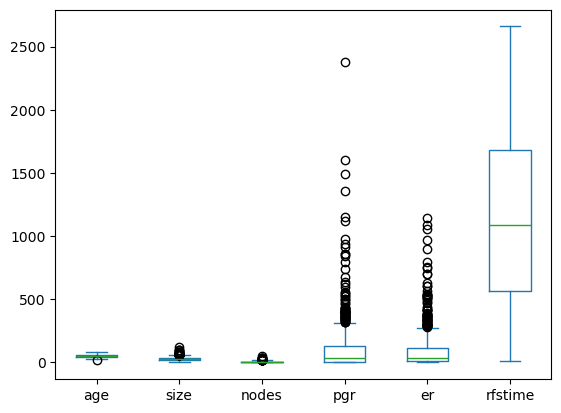

In [97]:
display(binary_df.hist(edgecolor='black'))
display(ordinal_df.hist(edgecolor='black', figsize=(3,2)))
display(continuous_df.hist(figsize=(8.5,6), bins=20, edgecolor='black'))
display(continuous_df.plot(kind='box'))

<Axes: title={'center': 'Breast Cancer Feature Correlation'}>

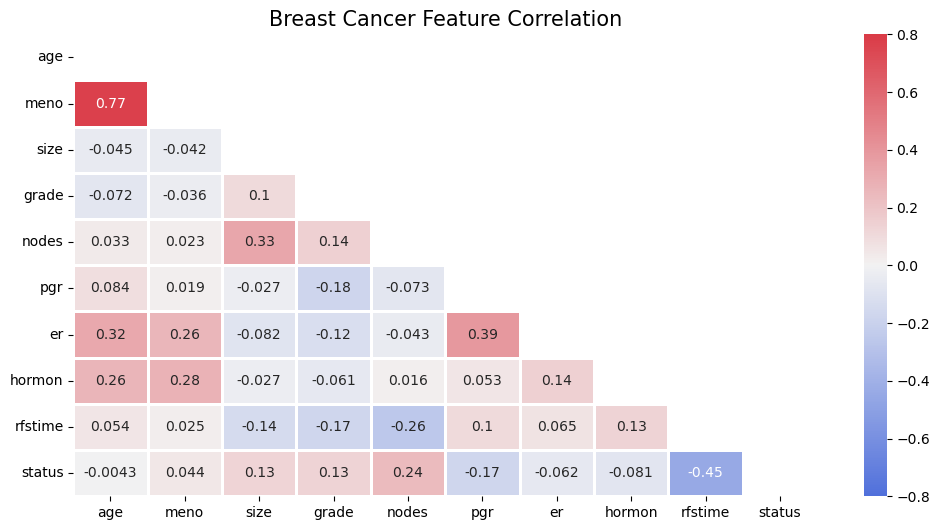

In [104]:
corrMatt = df.corr(numeric_only=True)

# mask for the upper triangle
# 0, 0, 0     1, 1, 1
# 0, 0, 0 --> 0, 1, 1
# 0, 0, 0     0, 0, 1
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = 1

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Breast Cancer Feature Correlation', fontsize=15)

# create custom heatmap colour scale
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt,
            vmax=0.8, vmin=-0.8, 
            square=False, 
            cmap=cmap, 
            mask=mask, # hides cells where there is a 1 as this means mask=True
            ax=ax,
            annot=True,
            fmt='.2g',
            linewidths=1)

# 3) use flower to aggregate summary statistics

In [ ]:
from datasets import Dataset
from torch.utils.data import DataLoader

NUM_CLIENTS = 10
BATCH_SIZE = 32

hugging_face_ds = Dataset.from_pandas(df)

def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="gbsg", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
        
    # Create train/val for each partition and wrap it into DataLoader
    trainloader = DataLoader(
        partition,
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    
    return trainloader

In [ ]:
from datasets import load_dataset

local_csv = load_dataset('csv', data_files='../data/gbsg.csv')

Generating train split: 686 examples [00:00, 4352.71 examples/s]
